# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [3]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [ ]:
df.sentiment.value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


*найбільше нейтрально забарвлених текстів, а вже негативних чи позитивних майже однакова кількість*

<Axes: >

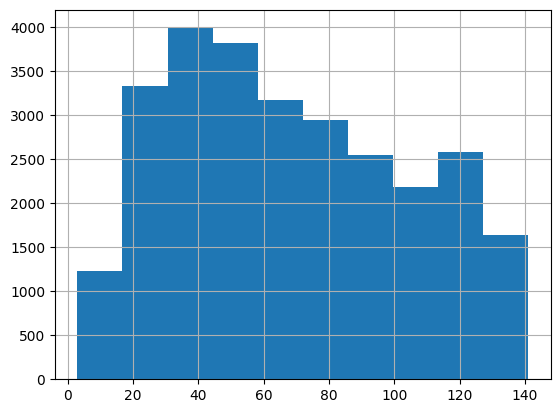

In [ ]:
df.text.str.len().hist()

*з гістограми видно, що найбільше текстів довжиною від 35 до майже 60 - середні речення*

*наступні по частоті теж короткі тексти, але всеодно найменше дуже коротких текстів або дуже довгих*

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [4]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import PunktSentenceTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
english_stopwords = stopwords.words('english')

In [7]:
stemmer = SnowballStemmer('english')

In [8]:
sent_tok = PunktSentenceTokenizer()

In [9]:
def tokenize(text: str):
    tokens = []
    for s in sent_tok.tokenize(text):
        s = s.lower()
        s = re.sub(r'[^a-z]+', ' ', s)
        words = s.split()
        for w in words:
            if w in english_stopwords or len(w) < 2:
                continue
            tokens.append(stemmer.stem(w)) # 4) стеммінг
    return tokens

In [10]:
vectorizer = CountVectorizer(tokenizer=tokenize, lowercase=False, max_features=5000)
inputs = vectorizer.fit_transform(df.text)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [11]:
inputs.shape

(27480, 5000)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs,
                                                            df.sentiment,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=df.sentiment)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [15]:
model_lr = LogisticRegression()
model_lr.fit(X_train_bow,y_train)
y_pred_lr = model_lr.predict(X_test_bow)
acc_lr = accuracy_score(y_test, y_pred_lr)

In [16]:
acc_lr

0.6866812227074236

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_bow,y_train)
y_pred_dt = model_dt.predict(X_test_bow)
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_dt

0.6419213973799127

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_bow,y_train)
y_pred_rf = model_rf.predict(X_test_bow)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_rf

0.6899563318777293

In [21]:
print(f"=== LogisticRegression ===\n",classification_report(y_test, y_pred_lr))
print(f"=== DecisionTree ===\n",classification_report(y_test, y_pred_dt))
print(f"=== RandomForest ===\n",classification_report(y_test, y_pred_rf))

=== LogisticRegression ===
               precision    recall  f1-score   support

    negative       0.70      0.63      0.67      1556
     neutral       0.63      0.71      0.67      2223
    positive       0.76      0.70      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496

=== DecisionTree ===
               precision    recall  f1-score   support

    negative       0.61      0.64      0.62      1556
     neutral       0.63      0.60      0.61      2223
    positive       0.68      0.70      0.69      1717

    accuracy                           0.64      5496
   macro avg       0.64      0.65      0.64      5496
weighted avg       0.64      0.64      0.64      5496

=== RandomForest ===
               precision    recall  f1-score   support

    negative       0.69      0.63      0.66      1556
     neutral       0.66      0.68      0.67      2223
   

*загалом непогано, найкраще себе показала логістична регресія якщо дивитись на f1-score, бо accuracy і логістичній і рандом форест майже однакова*

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [22]:
words = vectorizer.get_feature_names_out()

coefs = model_lr.coef_
classes = model_lr.classes_

coef_df = pd.DataFrame(coefs.T, index=words, columns=classes)

In [28]:
coef_df.head()

,negative,neutral,positive
aaaah,0.277417,-0.149692,-0.127725
aaahhh,0.211523,-0.205016,-0.006506
aah,0.508457,-0.582498,0.074041
aaron,-0.196877,0.297483,-0.100605
ab,-0.093239,-0.141074,0.234313


**для негативного класу**

виглядає досить логічно, слова як топ-10 показники негативного значення речення, і видно що останні слова по впливу для цього класу - це вже по суті ознаки "позитивного" класу

In [30]:
coef_df['negative'].sort_values(ascending=False).head(10)

,negative
sad,2.653971
suck,2.500084
sorri,2.463091
bore,2.408199
hate,2.341164
stupid,2.145360
miss,2.098180
fail,2.081707
worst,2.038085
exhaust,1.990794


In [29]:
coef_df['negative'].sort_values().head(10)

,negative
glad,-2.380288
awesom,-2.309522
love,-2.124940
beauti,-1.974467
thank,-1.915881
cute,-1.832091
welcom,-1.773894
amaz,-1.602091
enjoy,-1.600620
nice,-1.521811


**для позитивного класу**

впринципі тут теж все логічно і логіка гарно розподілена, як і в попердньому класі

In [33]:
coef_df['positive'].sort_values(ascending=False).head(10)

,positive
awesom,2.621390
cute,2.610782
thank,2.454135
love,2.377740
glad,2.321360
amaz,2.264976
enjoy,2.101269
excit,2.079185
bless,2.067098
nice,2.061062


In [31]:
coef_df['positive'].sort_values().head(10)

,positive
sorri,-2.601471
sad,-2.542528
shame,-2.437363
suck,-2.414960
bore,-2.270572
hate,-2.119190
horribl,-1.983759
miss,-1.919063
jealous,-1.870524
tire,-1.863903


**для нейтрального класу**

отут є певні питання, бо є слово-маркер расистське і воно не мало б відноситись до нейтрального класу

In [34]:
coef_df['neutral'].sort_values(ascending=False).head(10)

,neutral
indoor,1.624472
chan,1.562940
otherwis,1.287765
nigga,1.275867
oooo,1.268699
sp,1.249930
parvo,1.236835
colorado,1.225389
eu,1.115143
moro,1.105461


In [35]:
coef_df['neutral'].sort_values().head(10)

,neutral
forum,-1.428811
wtf,-1.395729
congratul,-1.341066
thrill,-1.318097
incred,-1.275683
proud,-1.237176
product,-1.228833
truli,-1.187300
accomplish,-1.180551
impati,-1.176592


### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
train_idx = y_train.index
test_idx  = y_test.index

In [43]:
vectorizerTF = TfidfVectorizer(tokenizer=tokenize, lowercase=False, max_features=5000)

In [44]:
X_train_tf = vectorizerTF.fit_transform(df.loc[train_idx, "text"])
X_test_tf  = vectorizerTF.transform(df.loc[test_idx,  "text"])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [50]:
model_tf = LogisticRegression()
model_tf.fit(X_train_tf, y_train)
y_pred_tf = model_tf.predict(X_test_tf)

In [51]:
acc_tf = accuracy_score(y_test, y_pred_tf)
acc_tf

0.6879548762736536

In [52]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

    negative       0.72      0.60      0.66      1556
     neutral       0.62      0.74      0.68      2223
    positive       0.77      0.69      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



якщо порівнювати тільки метрики, то TF-IDF не показала себе тут краще, а майже такк само як і Bag of Words

In [53]:
tfidf_words = vectorizerTF.get_feature_names_out()
coefs_tfidf = model_tf.coef_
classes = model_tf.classes_
coef_df_tfidf = pd.DataFrame(coefs_tfidf.T, index=tfidf_words, columns=classes)

**negative class**

тут так само гарно розподілило як і Bag of Words

In [54]:
coef_df_tfidf['negative'].sort_values(ascending=False).head(10)

,negative
sad,5.290150
miss,4.846976
sorri,4.664436
hate,4.426404
suck,4.291703
bore,3.954877
fail,3.689610
hurt,3.464550
stupid,3.425099
poor,3.316782


In [55]:
coef_df_tfidf['negative'].sort_values().head(10)

,negative
love,-5.005799
thank,-3.785001
hope,-3.350313
awesom,-3.325149
glad,-3.171112
great,-2.888263
nice,-2.507524
enjoy,-2.261600
amaz,-2.261349
cute,-2.226656


**positive class**

такий самий добрий результат

In [56]:
coef_df_tfidf['positive'].sort_values(ascending=False).head(10)

,positive
love,6.588172
thank,5.677449
awesom,4.894970
great,4.525671
happi,4.396079
good,4.317114
nice,4.311762
hope,4.077350
amaz,4.058443
enjoy,3.904729


In [57]:
coef_df_tfidf['positive'].sort_values().head(10)

,positive
sad,-4.084867
miss,-4.021683
sorri,-3.884777
suck,-3.101501
bore,-3.041617
tire,-2.892705
hate,-2.880649
shame,-2.399147
bad,-2.185248
sick,-2.140105


**neutral class**

а отут мені більше сподобалось як спрацював TF-IDF для нейтрального класу, дійсно на початку всі слова які не віднесеш ні до позитивного ні до негативного

In [58]:
coef_df_tfidf['neutral'].sort_values(ascending=False).head(10)

,neutral
indoor,1.300888
guitar,1.250228
except,1.139669
moro,1.104670
sp,1.051370
knock,0.995534
click,0.950958
grade,0.946586
otherwis,0.946475
starwarsday,0.945767


In [60]:
coef_df_tfidf['neutral'].sort_values().head(10)

,neutral
happi,-2.716717
good,-2.553007
fail,-2.040897
stupid,-1.948899
thank,-1.892448
funni,-1.888043
excit,-1.848593
perfect,-1.834009
nice,-1.804238
amaz,-1.797094


саме через це певно і вибрала б TF-IDF але ще б доопрацювати або обробку, або ще додати щось до алгоритму

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [65]:
errors = pd.DataFrame({
    "text": df.loc[y_test.index, "text"],
    "true": y_test,
    "pred": y_pred_tf
})

In [66]:
errors.head()

,text,true,pred
23414,Reading and taking notes but undertanding none...,negative,neutral
27364,so sad emma u sad to be leaving the show? ****,negative,negative
21261,Freakin` frustrated why can`t my coach realize...,negative,negative
11167,is feeling so bored... i miss school time,negative,negative
24609,wow this morning 8.15 hrs ding dong breakfasts...,positive,positive


In [67]:
len(errors)

5496

In [68]:
errors = errors[errors["true"] != errors["pred"]]

In [69]:
len(errors)

1715

In [70]:
errors.head(10)

,text,true,pred
23414,Reading and taking notes but undertanding none...,negative,neutral
4127,Hoping that this will just heal on it`s own be...,neutral,negative
4832,yum. Do you do home delivery,positive,neutral
19360,Having a wonderful piece of cake for lunch - w...,positive,neutral
24967,"Don`t worry, you`ll get your stamina back soo...",positive,neutral
10652,shack idol today(: can`t wait. it`s gonna be f...,neutral,negative
17484,"Awww, *hugs* I wish I could help.",negative,positive
7936,2 hours after teleconference. but can`t go bac...,negative,neutral
10247,Youtube isn`t working...and I wanted to watch ...,negative,neutral
3704,**** Frat - that`s too bad... Should be a go...,neutral,positive


In [74]:
print(errors.loc[23414, 'text'])

Reading and taking notes but undertanding none of it  ... HELP!


тут я на стороні моделі)) бо теж б не поставила це в негативний клас

In [75]:
print(errors.loc[4127, 'text'])

Hoping that this will just heal on it`s own because anything I put on it just makes it worse. Owww


тут насправді для мене не зрозуміло чому модель обрала негативний клас

як покращити результат

1.   покращити обробку до
2.   спробувати інші методи векторизації



І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model